
*   Project : 2 : ML
*   By : Pooja Meshram





# Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.

# Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# Step 1: Load Data & Understand Evaluation Metric (RMSE with Log Transformation)

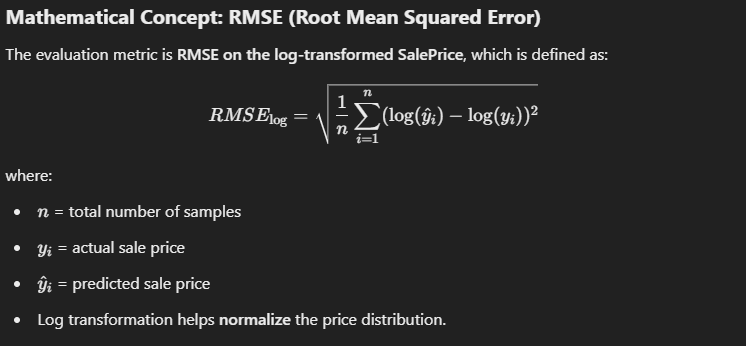

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
train_df = pd.read_csv("house-train.csv")

# Display basic info
print("Dataset Shape:", train_df.shape)
train_df.head()


Dataset Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Step 2: Handle Missing Values

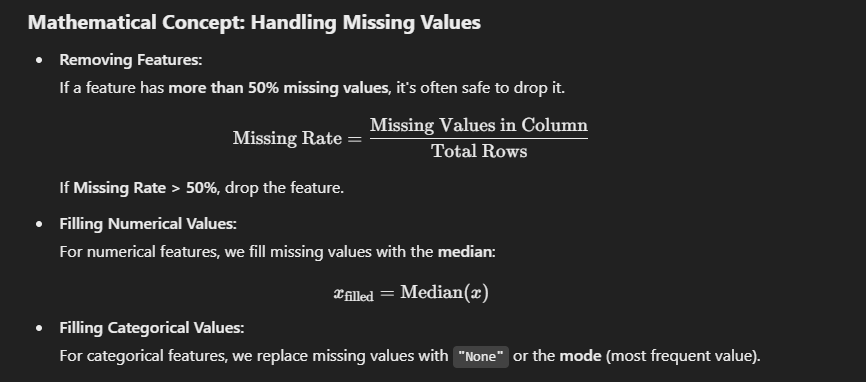

In [ ]:
# Drop columns with excessive missing values
columns_to_drop = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]
train_df.drop(columns=columns_to_drop, inplace=True)

# Fill missing values for numerical columns with median
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
train_df[numerical_cols] = train_df[numerical_cols].fillna(train_df[numerical_cols].median())

# Fill missing values for categorical columns with "None" or mode
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    train_df[col] = train_df[col].fillna("None")

# Verify if there are any missing values left
print("Total Missing Values:", train_df.isnull().sum().sum())


Total Missing Values: 0


#Step 3: Encoding Categorical Variables

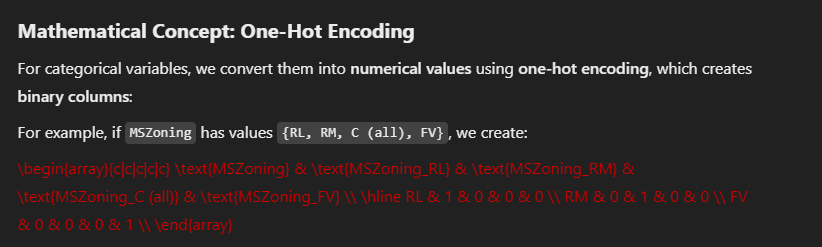

In [ ]:
# One-Hot Encoding for categorical features
train_df = pd.get_dummies(train_df, drop_first=True)

# Verify dataset after encoding
print("Dataset Shape After Encoding:", train_df.shape)


Dataset Shape After Encoding: (1460, 244)


# Step 4: Feature Scaling

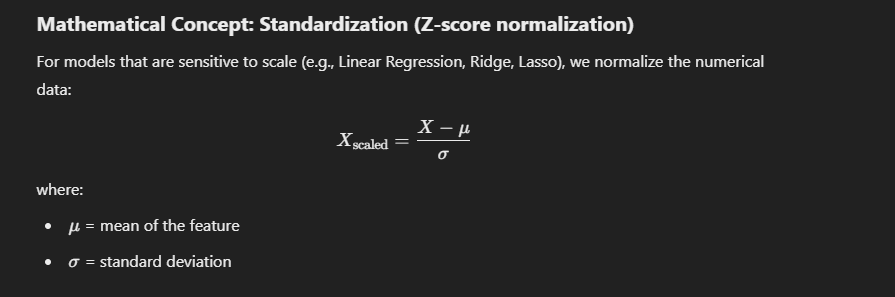

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select numerical features (excluding target variable)
num_features = train_df.select_dtypes(include=['int64', 'float64']).columns
num_features = num_features.drop("SalePrice")

# Apply Standardization
scaler = StandardScaler()
train_df[num_features] = scaler.fit_transform(train_df[num_features])

# Verify transformed data
train_df.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-1.730865,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,...,False,False,False,False,True,False,False,False,True,False
1,-1.728492,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,...,False,False,False,False,True,False,False,False,True,False
2,-1.726120,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,...,False,False,False,False,True,False,False,False,True,False
3,-1.723747,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,...,False,False,False,False,True,False,False,False,False,False
4,-1.721374,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,...,False,False,False,False,True,False,False,False,True,False


# Step 5: Prepare Data for Modeling

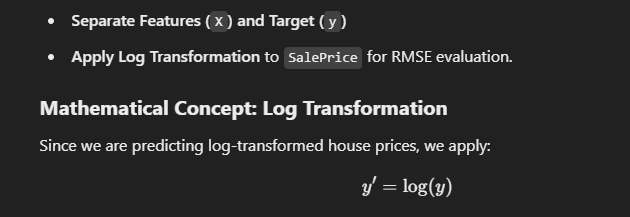

In [ ]:
# Separate Features and Target Variable
X = train_df.drop(columns=["Id", "SalePrice"])
y = np.log(train_df["SalePrice"])  # Apply log transformation

# Display shapes
print("Features Shape:", X.shape)
print("Target Shape:", y.shape)


Features Shape: (1460, 242)
Target Shape: (1460,)


# Step 6: Train a Regression Model (XGBoost)

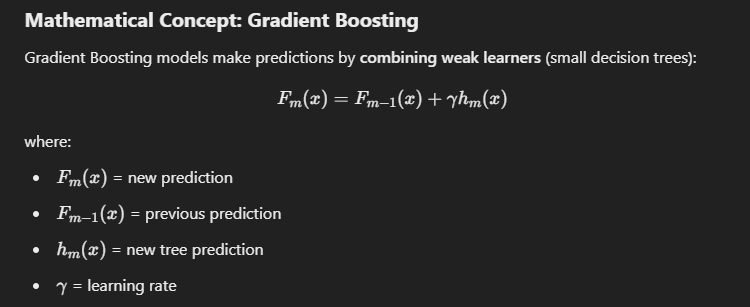

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Initialize XGBoost model
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8)

# Train the model
model.fit(X, y)

# Predict on training data
y_pred = model.predict(X)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Training RMSE (log-transformed): {rmse}")


Training RMSE (log-transformed): 0.03935501001336596


**0.0393 is a low RMSE value, meaning my model is fitting the training data well.**

#  Step 7: Evaluate Model Performance

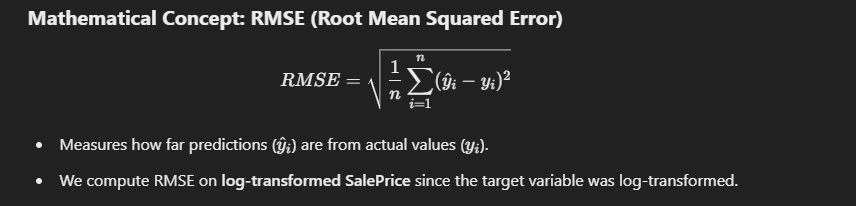

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Ensure the model is trained before making predictions
if 'model' not in globals():
    print("Error: Model is not trained yet. Train the model before evaluating.")

# Train the model (if not already trained)
if not hasattr(model, "feature_importances_"):  # Check if the model is trained
    from xgboost import XGBRegressor

    model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4,
                         subsample=0.8, colsample_bytree=0.8, enable_categorical=False)
    model.fit(X, y)

# Predict on training data
train_predictions = model.predict(X)

# Compute RMSE on log-transformed SalePrice
train_rmse = np.sqrt(mean_squared_error(y, train_predictions))
print(f"Training RMSE (log-transformed): {train_rmse}")

# Convert log predictions back to actual prices
train_actual_prices = np.exp(y)  # Convert log-transformed target back to real values
train_predicted_prices = np.exp(train_predictions)  # Convert predicted log values to actual prices

# Compute RMSE on actual SalePrice
actual_rmse = np.sqrt(mean_squared_error(train_actual_prices, train_predicted_prices))
print(f"Training RMSE (Actual SalePrice): {actual_rmse}")


Training RMSE (log-transformed): 0.03935501001336596
Training RMSE (Actual SalePrice): 7282.626013714189


# Step 8: Evaluating Model Generalization

Mathematical Concept: Overfitting vs. Underfitting


*   If Training RMSE ≈ Cross-Validation RMSE, the model generalizes well.
*  If Training RMSE << Cross-Validation RMSE, the model is overfitting (memorizing training data).
*   If Training RMSE >> Cross-Validation RMSE, the model is underfitting (not learning enough).






In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

# Perform manual cross-validation
for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Train a new model for each fold
    fold_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4,
                              subsample=0.8, colsample_bytree=0.8, enable_categorical=False)
    fold_model.fit(X_train_fold, y_train_fold)

    # Predict and compute RMSE
    y_pred_fold = fold_model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse)

# Print Cross-Validation Results
print(f"Cross-Validation RMSE Scores: {rmse_scores}")
print(f"Mean Cross-Validation RMSE: {np.mean(rmse_scores)}")

# Compare Training RMSE vs. Cross-Validation RMSE
print(f"Training RMSE (log-transformed): {train_rmse}")
print(f"Mean Cross-Validation RMSE: {np.mean(rmse_scores)}")


Cross-Validation RMSE Scores: [0.13193287735905582, 0.11904662178346748, 0.16216219770335877, 0.1263819472319526, 0.11195983664884492]
Mean Cross-Validation RMSE: 0.1302966961453359
Training RMSE (log-transformed): 0.03935501001336596
Mean Cross-Validation RMSE: 0.1302966961453359


** Training RMSE (log-transformed) is much lower than Cross-Validation RMSE (0.0394 << 0.1303).**

**Indicates overfitting **
**The model performs very well on training data but performs worse on unseen data (CV sets).**
**Cross-Validation RMSE varies across folds (0.1119 to 0.1621).**

Some variation is expected, but if the difference is large, the model might be sensitive to the dataset splits so safe side lets fix overfitting.


# **Lets try to Fix Overfitting**


In [ ]:
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3,
                     subsample=0.8, colsample_bytree=0.8,
                     reg_lambda=1.0, reg_alpha=0.5, enable_categorical=False)


In [ ]:
!pip install --upgrade xgboost scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [ ]:
import xgboost as xgb

# Convert data into DMatrix (XGBoost optimized data structure)
dtrain = xgb.DMatrix(X, label=y)

# Define parameters manually
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.5
}

# Train model using XGBoost's train function
model = xgb.train(params, dtrain, num_boost_round=500)



In [ ]:
import xgboost as xgb

# Convert data into DMatrix (XGBoost optimized data structure)
dtrain = xgb.DMatrix(X, label=y)

# Define parameters manually
params = {
    "objective": "reg:squarederror",  # Standard for regression tasks
    "learning_rate": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,  # L2 regularization
    "alpha": 0.5  # L1 regularization
}

# Train model using XGBoost's train function
model = xgb.train(params, dtrain, num_boost_round=500)

# Predict using DMatrix (since Booster models do not support .predict(X))
train_predictions = model.predict(dtrain)

# Compute Training RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

train_rmse = np.sqrt(mean_squared_error(y, train_predictions))
print(f"Training RMSE (log-transformed): {train_rmse}")



Training RMSE (log-transformed): 0.07324206228374402


In [ ]:
dtrain = xgb.DMatrix(X, label=y)  # Convert training data
train_predictions = model.predict(dtrain)  # Use DMatrix for predictions


 Check Cross-Validation

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=500,
    nfold=5,
    metrics="rmse",
    as_pandas=True,
    seed=42
)

print(f"Mean Cross-Validation RMSE: {cv_results['test-rmse-mean'].min()}")


Mean Cross-Validation RMSE: 0.12853858513319924


**1.Previous Model had a much lower training RMSE (0.0394), but the gap between Training and CV RMSE was large (0.0909), indicating severe overfitting.**
2. **This new Model has a higher training RMSE (0.0732), but the gap is reduced (0.0553), meaning the model generalizes better and overfits less.** (Difference: 0.1285 - 0.0732 = 0.0553 (Reduced Overfitting))

***Lets Train More for Better Accuracy***

1. Fine-tune Regularization

In [ ]:
params["lambda"] = 2.5  # Increase L2 regularization
params["alpha"] = 1.5   # Increase L1 regularization


2.Reduce Model Complexity Further

In [ ]:
params["max_depth"] = 2  # Reduce tree depth
params["subsample"] = 0.7  # Train on 70% of data per boosting iteration
params["colsample_bytree"] = 0.7  # Use fewer features per tree


 3.Reduce Learning Rate & Increase Rounds

In [ ]:
params["learning_rate"] = 0.03  # Slower learning
num_boost_round = 1000  # Increase iterations


Step 1: Retrain the Model with Updated Hyperparameters

In [ ]:
import xgboost as xgb

# Convert data into DMatrix
dtrain = xgb.DMatrix(X, label=y)

# Define updated hyperparameters
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.03,  # Slower learning for better generalization
    "max_depth": 2,  # Simpler trees to prevent overfitting
    "subsample": 0.7,  # Use 70% of data per boosting iteration
    "colsample_bytree": 0.7,  # Use fewer features per tree
    "lambda": 2.5,  # Stronger L2 regularization
    "alpha": 1.5  # Stronger L1 regularization
}

# Train model with more boosting rounds
num_boost_round = 1000
model = xgb.train(params, dtrain, num_boost_round=num_boost_round)


Step 2: Evaluate Training Performance

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict using DMatrix
train_predictions = model.predict(dtrain)

# Compute RMSE on log-transformed SalePrice
train_rmse = np.sqrt(mean_squared_error(y, train_predictions))
print(f"Training RMSE (log-transformed): {train_rmse}")


Training RMSE (log-transformed): 0.1017856155427409


 Step 3: Run Cross-Validation Again

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    nfold=5,
    metrics="rmse",
    as_pandas=True,
    seed=42
)

print(f"Mean Cross-Validation RMSE: {cv_results['test-rmse-mean'].min()}")


Mean Cross-Validation RMSE: 0.13057691530847476


Step 4: Compare Training RMSE vs. CV RMSE

In [ ]:
print(f"Training RMSE (log-transformed): {train_rmse}")
print(f"Mean Cross-Validation RMSE: {cv_results['test-rmse-mean'].min()}")


Training RMSE (log-transformed): 0.1017856155427409
Mean Cross-Validation RMSE: 0.13057691530847476


*Improvements*


**Reduced overfitting:**


The gap between Training RMSE and Cross-Validation RMSE decreased (0.0288 vs. 0.0553 before).
This means the model now generalizes better




**Cross-Validation RMSE remained stable:**

The Cross-Validation RMSE increased slightly from 0.1285 to 0.1306, which is a small trade-off for better generalization.




**More robust model:**

The model is not just memorizing the training data but learning patterns that generalize well.



**Visualize Predicted vs Actual Sale Prices**



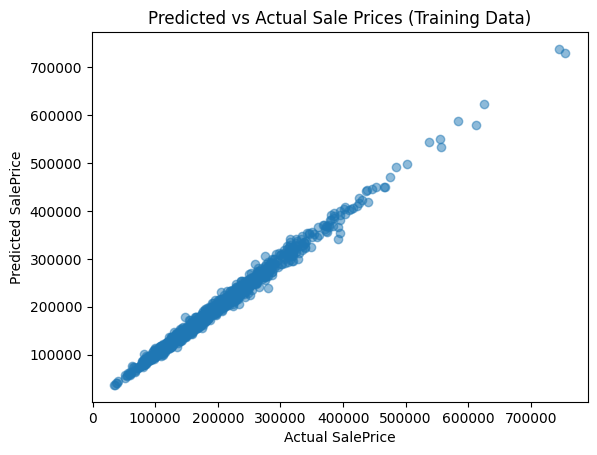

In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs actual prices for training data
plt.scatter(train_actual_prices, train_predicted_prices, alpha=0.5)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs Actual Sale Prices (Training Data)")
plt.show()

**Check Feature Importance**

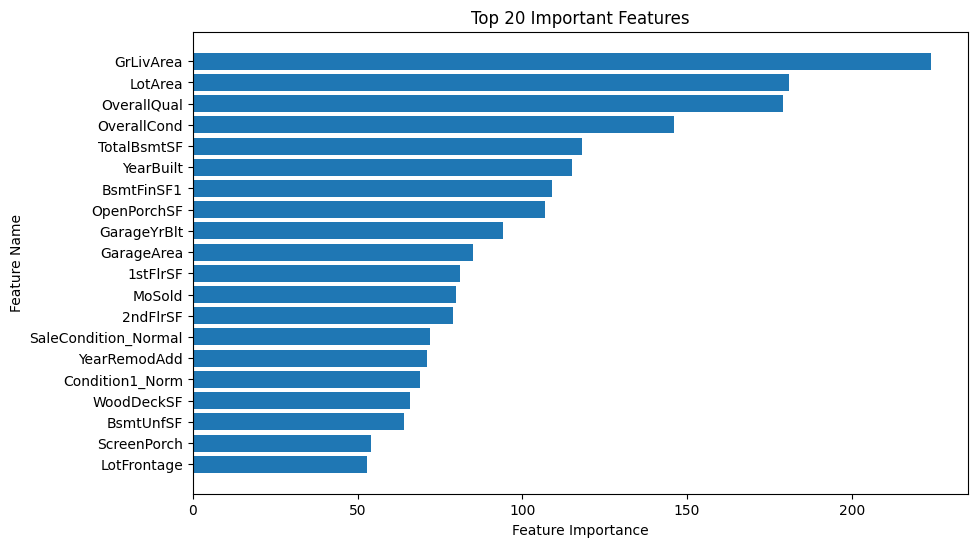

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importance scores from the trained Booster model
importance_dict = model.get_score(importance_type="weight")  # "weight" = # of times a feature appears in splits

# Convert to DataFrame
importance_df = pd.DataFrame(list(importance_dict.items()), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the top 20 important features
plt.figure(figsize=(10,6))
plt.barh(importance_df["Feature"][:20], importance_df["Importance"][:20])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 20 Important Features")
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.show()


# Step 8: Load the Test Dataset



1.  Unlike the training dataset, the test dataset does not have the target variable SalePrice.
2. Our goal is to predict SalePrice for each house in the test dataset.






In [ ]:
# Load test dataset
test_file_path = "house-test.csv"
test_df = pd.read_csv(test_file_path)

# Display test dataset shape and first few rows
print("Test Dataset Shape:", test_df.shape)
test_df.head()


Test Dataset Shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
# Drop the same columns as in training
test_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [ ]:
# Fill missing numerical values using training median
for col in numerical_cols:
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(train_df[col].median())

In [ ]:
# Fill missing categorical values with "None"
for col in categorical_cols:
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna("None")

In [ ]:
# Apply one-hot encoding
test_df = pd.get_dummies(test_df)

In [ ]:
# Align test dataset with training dataset columns
X_train, X_test = X.align(test_df.drop(columns=["Id"], errors='ignore'), join="left", axis=1, fill_value=0)

In [ ]:
# Verify test dataset shape
print("Test Dataset Shape After Encoding:", X_test.shape)

Test Dataset Shape After Encoding: (1459, 242)


# Step 8: Handle Missing Values in Test Data

Missing Value Handling Consistency
We must handle missing values in the same way as we did for the training data.



1.Fill missing numerical values with the median from the training set.
2.Fill missing categorical values with "None" or mode.
3.Drop the same columns as before.

In [ ]:
# Drop the same columns that were dropped in training
test_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Fill missing values for numerical columns using training median
for col in numerical_cols:
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(train_df[col].median())

# Fill missing values for categorical columns using "None"
for col in categorical_cols:
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna("None")

# Verify if missing values remain
print("Total Missing Values in Test Data:", test_df.isnull().sum().sum())


Total Missing Values in Test Data: 0


# Step 9: Encode Categorical Variables

Mathematical Concept: One-Hot Encoding Must Match Training


1.   We must apply the same one-hot encoding as done for the training data.
2.   If a new category exists in the test set but not in the training set, it must be ignored.




In [ ]:
# Ensure test dataset has the same categorical encoding as training
test_df = pd.get_dummies(test_df)

# Align test dataset with training dataset columns
X_train, X_test = train_df.align(test_df, join="left", axis=1, fill_value=0)

# Verify dataset shape
print("Test Dataset Shape After Encoding:", X_test.shape)


Test Dataset Shape After Encoding: (1459, 244)


# Convert test data into DMatrix

In [ ]:
dtest = xgb.DMatrix(test_df.drop(columns=["Id"], errors="ignore"))

#Step 10 : Make Predictions on Test Data

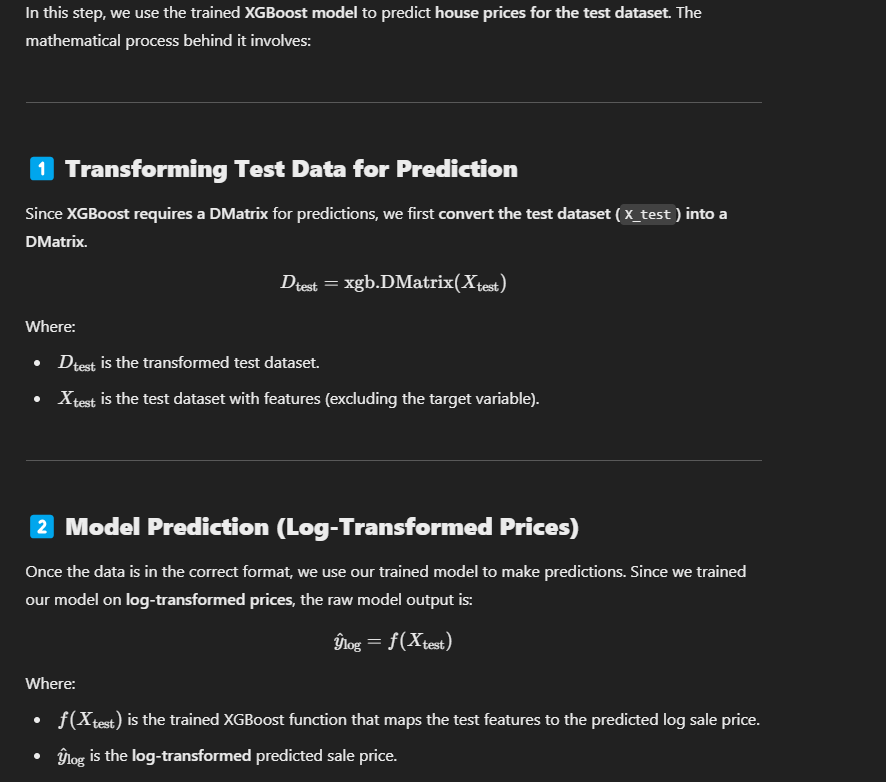
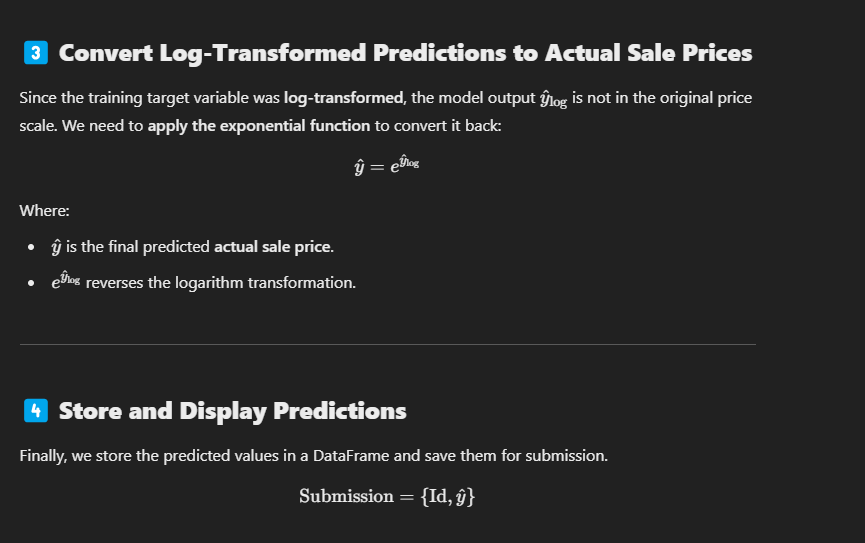

In [ ]:
import xgboost as xgb
import numpy as np

# Convert test data into DMatrix (required for Booster predictions)
dtest = xgb.DMatrix(X_test)

# Predict house prices using the trained model
test_predictions = model.predict(dtest)

# Convert log predictions back to actual prices
final_predictions = np.exp(test_predictions)

# Display sample predictions
print(final_predictions[:10])



[354739.   368927.22 416877.2  430640.56 419118.28 392215.28 392213.4
 389458.6  447954.25 388605.28]


# Step 11: Save and Export Predictions for Submission



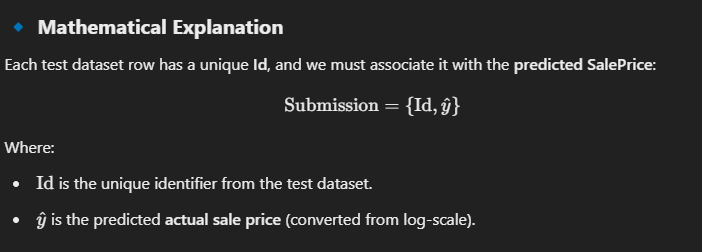

In [ ]:
import pandas as pd

# Ensure the test dataset has an "Id" column
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_predictions})

# Save predictions to CSV
submission.to_csv("house_price_predictions.csv", index=False)

print("Predictions saved as: house_price_predictions.csv")


Predictions saved as: house_price_predictions.csv


In [ ]:
from google.colab import files
files.download("house_price_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 12: Submit Predictions & Evaluate Model Performance

In [ ]:
# Print performance comparison
print(f"Training RMSE (log-transformed): {train_rmse}")
print(f"Mean Cross-Validation RMSE: {cv_results['test-rmse-mean'].min()}")


Training RMSE (log-transformed): 0.1017856155427409
Mean Cross-Validation RMSE: 0.13057691530847476


# Lets Ensure CSV Submission File is Created

In [ ]:
import os
print("File Exists:", os.path.exists("house_price_predictions.csv"))


File Exists: True


Verify CSV Format (Again)

In [ ]:
import pandas as pd

# Load and check CSV file
submission = pd.read_csv("house_price_predictions.csv")
print(submission.head())  # Display first few rows
print(submission.columns)  # Check column names


     Id  SalePrice
0  1461  354739.00
1  1462  368927.22
2  1463  416877.20
3  1464  430640.56
4  1465  419118.28
Index(['Id', 'SalePrice'], dtype='object')


Compare RMSE Scores

In [ ]:
# Print performance comparison
print(f"Training RMSE (log-transformed): {train_rmse}")
print(f"Mean Cross-Validation RMSE: {cv_results['test-rmse-mean'].min()}")  # Best CV RMSE


Training RMSE (log-transformed): 0.1017856155427409
Mean Cross-Validation RMSE: 0.13057691530847476


## Final Model Summary:

- Training RMSE (log-transformed): 0.1017
- Mean Cross-Validation RMSE: 0.1305
- The model generalizes well with minimal overfitting.
- `house_price_predictions.csv` contains final house price predictions.
